# Model module tutorial

This tutorial is a part of Model module guide. Here, we explore how you can use the KerasModel wrapper to use your Keras deep learning models in the benchmark.

In [1]:
# If you are executing this notebook at a location different than root, you need to add it to
# the path.
import sys
sys.path.insert(0,'../../')

In [2]:
# Python packages
import gc
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

In [3]:
# Keras imports
import keras
import tensorflow as tf

from keras import layers, models

Using TensorFlow backend.


In [4]:
# Benchmark modules
from OpenDenoising import data
from OpenDenoising import model
from OpenDenoising import evaluation

In [5]:
# Configuring the default session for Keras and Tensorflow

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
keras.backend.set_session(session)

In [6]:
def display_results(clean_imgs, noisy_imgs, rest_images, name):
    """Display denoising results."""
    fig, axes = plt.subplots(5, 3, figsize=(15, 15))
    
    plt.suptitle("Denoising results using {}".format(name))

    for i in range(5):
        axes[i, 0].imshow(np.squeeze(clean_imgs[i]), cmap="gray")
        axes[i, 0].axis("off")
        axes[i, 0].set_title("Ground-Truth")

        axes[i, 1].imshow(np.squeeze(noisy_imgs[i]), cmap="gray")
        axes[i, 1].axis("off")
        axes[i, 1].set_title("Noised Image")

        axes[i, 2].imshow(np.squeeze(rest_imgs[i]), cmap="gray")
        axes[i, 2].axis("off")
        axes[i, 2].set_title("Restored Images")

In [7]:
data.download_BSDS_grayscale(output_dir="../../tmp/BSDS500/")

In [8]:
# Training images generator
train_generator = data.DatasetFactory.create(path="../../tmp//BSDS500/Train",
                                             batch_size=8,
                                             n_channels=1,
                                             noise_config={data.utils.gaussian_noise: [25]},
                                             preprocessing=[partial(data.gen_patches, patch_size=40),
                                                            partial(data.dncnn_augmentation, aug_times=1)],
                                             name="BSDS_Train")

In [9]:
# Validation images generator
valid_generator = data.DatasetFactory.create(path="../../tmp/BSDS500/Valid",
                                             batch_size=8,
                                             n_channels=1,
                                             noise_config={data.utils.gaussian_noise: [25]},
                                             name="BSDS_Valid")

# Keras Model <a class="anchor" id="keras-model"></a>
---
Keras offers two ways to construct a model, whether by explicitly programming it using their API, or by using a file to load the computational graph. Once you have constructed your model, you will have at hand a "keras.models.Model" class instance.

Since the use of different frameworks is not the same, to force Keras models to adequate their functionality to the Benchmark needs, we provide the KerasModel class, that redefines some of the Keras API functionalities.

# Navigation
---

* [Charging a model](#keras-charging-a-model)
    * [From a function](#keras-from-func)
    * [From a file](#keras-from-file)
* [Running inference](#keras-running-inference)
* [Training a KerasModel](#training-a-kerasmodel)

## Charging a model <a class="anchor" id="keras-charging-a-model"></a>
---

The first step to build a KerasModel instance, is to effectively charge a keras model ("keras.models.Model") into the class. This is done through the method "__charge_model__". There are two ways to charge the model into the wrapper class: by using a function, or by using a file. These two cases are managed by the use of three parameters of the method "__charge_model__":

* __model_function__: This argument receives a function object (with \_\_call\_\_ method defined). The function object is responsable to build the Keras model inside the class.
* __model_path__: This argument is a string containing the path to a .hdf5 file (weights + architecture) or a .json/.yaml file (architecture).
* __model_weights__: If you passed the model architecture through a .json file, and you do have a .hdf5 containing weights only, you can pass the path to the .hdf5 weight file using the "model_weights" parameter.

### From a function <a class="anchor" id="keras-from-func"></a>

To charge a "keras.models.Model" into the wrapper class, you need to explicitly program the Keras model. To do so, you should provide to the method "__charge_model__" a function that returns an instance of "keras.models.Model" class corresponding to your architecture. As an example, consider the following implementation of [DnCNN network](https://arxiv.org/pdf/1608.03981.pdf):

```Python
def dncnn():
    x = layers.InputLayer(shape=[None, None, 1])
    y = layers.Conv2D(filters=64, kernel_size=5, strides=(1, 1), padding='same')(x)
    y = layers.Activation("relu")(y)

    # Middle layers: Conv + ReLU + BN
    for i in range(1, 16):
        y = layers.Conv2D(filters=64, kernel_size=5, strides=(1, 1), padding='same', use_bias=False)(y)
        y = layers.BatchNormalization(axis=-1, momentum=0.0, epsilon=1e-3)(y)
        y = layers.Activation("relu")(y)
  
    y = layers.Conv2D(filters=1, kernel_size=5, strides=(1, 1), use_bias=False, padding='same')(y)
    y = layers.Subtract()([x, y])

    # Keras model
    return models.Model(x, y)
```

additionally to this example, you should consider the following convention to architecture functions:

```Python
def my_arch_func(optional arguments):
    # Steps to build your Keras model
    return keras.models.Model(inputs, outputs)
```

In the following blocks of code, we show how we can charge the model into a "KerasModel" wrapper class by using the "dncnn" function.

In [10]:
# Creating the KerasModel instance
kerasmodel_ex1 = model.KerasModel(model_name="Example1", logdir="../../logs/Keras")
print("KerasModel {} created succesfully.".format(kerasmodel_ex1))

KerasModel Example1 created succesfully.


In [11]:
# Defining the function to be charged
def dncnn():
    x = layers.Input(shape=[None, None, 1])
    y = layers.Conv2D(filters=64, kernel_size=5, strides=(1, 1), padding='same')(x)
    y = layers.Activation("relu")(y)

    # Middle layers: Conv + ReLU + BN
    for i in range(1, 16):
        y = layers.Conv2D(filters=64, kernel_size=5, strides=(1, 1), padding='same', use_bias=False)(y)
        y = layers.BatchNormalization(axis=-1, momentum=0.0, epsilon=1e-3)(y)
        y = layers.Activation("relu")(y)
  
    y = layers.Conv2D(filters=1, kernel_size=5, strides=(1, 1), use_bias=False, padding='same')(y)
    y = layers.Subtract()([x, y])

    # Keras model
    return models.Model(x, y)

In [12]:
# Charging model into Example1
kerasmodel_ex1.charge_model(model_function=dncnn)

W0902 10:47:13.272264 140353946789696 keras_model.py:119] You have loaded your model from a python function, which does not hold any information about weight values. Be sure to train the network before running your tests.


Notice the previous warning:

    W0821 09:12:14.533067 140116547233600 keras_model.py:118] You have loaded your model from a python function, which does not hold any information about weight values. Be sure to train the network before running your tests.
    
since you have loaded the model without any information about its weights, we remark that you should run a training session before performing inference.

Finally, it may be the case that your architecture has additional parameters. Consider the following example,

```Python
def dncnn(depth=17, n_filters=64, kernel_size=(3, 3), n_channels=1):
    x = layers.Input(shape=[None, None, 1])
    y = layers.Conv2D(filters=n_filters, kernel_size=kernel_size, strides=(1, 1), padding='same')(x)
    y = layers.Activation("relu")(y)

    # Middle layers: Conv + ReLU + BN
    for i in range(1, depth - 1):
        y = layers.Conv2D(filters=n_filters, kernel_size=kernel_size, strides=(1, 1), padding='same', use_bias=False)(y)
        y = layers.BatchNormalization(axis=-1, momentum=0.0, epsilon=1e-3)(y)
        y = layers.Activation("relu")(y)
  
    y = layers.Conv2D(filters=1, kernel_size=kernel_size, strides=(1, 1), use_bias=False, padding='same')(y)
    y = layers.Subtract()([x, y])

    # Keras model
    return models.Model(x, y)
```

this corresponds to the same architecture as the previous DnCNN, except that it has additional parameters, such as "depth", "n_filters", "kernel_size" and "n_channels". You can still pass these to the charge_model function,

In [13]:
def dncnn_opt_params(depth=17, n_filters=64, kernel_size=(3, 3), n_channels=1):
    x = layers.Input(shape=[None, None, n_channels])
    y = layers.Conv2D(filters=n_filters, kernel_size=kernel_size, strides=(1, 1), padding='same')(x)
    y = layers.Activation("relu")(y)

    # Middle layers: Conv + ReLU + BN
    for i in range(1, depth - 1):
        y = layers.Conv2D(filters=n_filters, kernel_size=kernel_size, strides=(1, 1), padding='same', use_bias=False)(y)
        y = layers.BatchNormalization(axis=-1, momentum=0.0, epsilon=1e-3)(y)
        y = layers.Activation("relu")(y)
  
    y = layers.Conv2D(filters=1, kernel_size=kernel_size, strides=(1, 1), use_bias=False, padding='same')(y)
    y = layers.Subtract()([x, y])

    # Keras model
    return models.Model(x, y)

In [14]:
kerasmodel_ex2 = model.KerasModel(model_name="Example2", logdir="../../logs/Keras")
print("KerasModel {} created succesfully.".format(kerasmodel_ex2))
kerasmodel_ex2.charge_model(model_function=dncnn_opt_params, depth=20, kernel_size=(7, 7), n_channels=3)

KerasModel Example2 created succesfully.


W0902 10:47:45.332327 140353946789696 keras_model.py:119] You have loaded your model from a python function, which does not hold any information about weight values. Be sure to train the network before running your tests.


In [15]:
kerasmodel_ex1.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 1 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 6 1664        input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 6 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, None, None, 6 102400      activation_1[0][0]               
__________________________________________________________________________________________________
batch_norm

In [16]:
kerasmodel_ex2.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, None, None, 6 9472        input_2[0][0]                    
__________________________________________________________________________________________________
activation_17 (Activation)      (None, None, None, 6 0           conv2d_18[0][0]                  
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, None, None, 6 200704      activation_17[0][0]              
__________________________________________________________________________________________________
batch_norm

### From a file <a class="anchor" id="keras-from-file"></a>

There are two ways of charging a model from a file:

1. Charging an architecture (without weights) through a .json or .yaml file. This is done through a model previously saved using "keras.models.Model.to_json()" or "keras.models.Model.to_yaml()" method. As an example, consider the following:

```Python
net = dncnn()
net.to_json("path_to_save_your_json_file")
net.to_yaml("path_to_save_your_yaml_file")
```

In those two cases, the network is saved without any information about its training or weights, so you should run a training session before using your model for inference.

2. Charging the complete model (weights + architecture) using a .json/.yaml file + .hdf5 file, or only a .hdf5 file. Keras can save either only weights or weights + architecture into a .hdf5 file. That depends on the commands you have used, for instance,

```Python
net = dncnn()
# Training of neural net
net.save("model.hdf5") # This saves both weights and architecture.
net.save_weights("weights.hdf5") # This saves only the weights.
```

To charge a model using a file, you simply need to pass it to "__charge_model__" through the "model_path" parameters. An example is shown bellow, on [Running Inference](#keras-running-inference).

In [17]:
# Frees memory
kerasmodel_ex1 = None
kerasmodel_ex2 = None
gc.collect()

290

In [18]:
# Loads model from .hdf5 file.
kerasmodel_ex3 = model.KerasModel(model_name="Inference_ex1", logdir="../../logs/Keras")
kerasmodel_ex3.charge_model(model_path="../../pretrained_models/Keras/dncnn/model.hdf5")

/home/efernand/repos/Summer_Internship_2019/venv/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


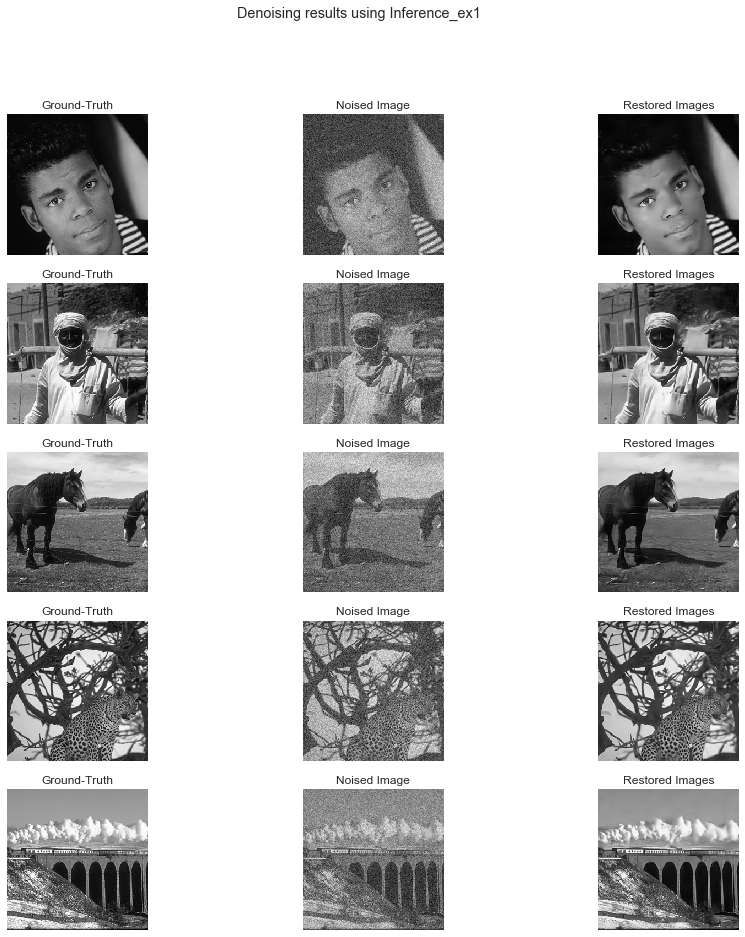

In [19]:
# Get batch from valid_generator
noisy_imgs, clean_imgs = next(valid_generator)
# Performs inference on noisy images
rest_imgs = kerasmodel_ex3(noisy_imgs)
display_results(clean_imgs, noisy_imgs, rest_imgs, str(kerasmodel_ex3))

In [20]:
kerasmodel_ex3 = None
gc.collect()

25129

### Training a KerasModel <a class="anchor" id="training-a-kerasmodel"></a>

To run a training session, you only need to have a dataset, such as defined in the DatasetUsage.ipynb. Once you created a DatasetGenerator for your training images (and possibly, for you validation images) you can call the "__train__" method from KerasModel class, which takes the following parameters,

* train_generator: any instance of a dataset generator class. This class will yield the data pairs.
* valid_generator: optional. Specify it if you have validation data at hand.
* n_epochs: number of training epochs. Default is 100.
* n_stages: number of training batches drawn at random from the dataset at each training epoch. Default value is 500.
* learning_rate: constant regulating the weight updates in your model. Default is 1e-3.
* optimizer_name: you can specify the optimizer's name for you model. You can do this by lookin at the names in [Keras documentation](https://keras.io/optimizers/). Default is "Adam" optimizer.
* metrics: list of metrics that will be tracked during training. There are a couple of useful metrics implemented on __evaluation__ module (such as PSNR, SSIM, MSE) but you can also implement your own following [Keras conventions](https://keras.io/metrics/).
* kcallbacks: list of Keras callbacks. You can either use [Keras default callbacks](https://keras.io/callbacks/) or the callbacks defined on __evaluation__ module.
* loss: A metric that will be used in optimization as the objective function to be minimized.
* valid_steps: number of validation batches drawn at each validation epoch.

To show how a keras model can be trained, consider the training of a DnCNN as stated on its [original paper](https://arxiv.org/pdf/1608.03981.pdf):

* DnCNN for gaussian denoising has depth 17, n_filters 64, kernel_size (3, 3).
* It is trained on $40 \times 40$ patches extracted from BSDS images, corrupted with fixed-variance gaussian noise ($\sigma=25$, for instance).

For evaluation, we will use a disjoint subset of BSDS, consisting on 68 images which are not present in the training dataset.

In [21]:
# KerasModel
kerasmodel_ex4 = model.KerasModel(model_name="Example4", logdir="../../logs/Keras")
print("KerasModel {} created succesfully.".format(kerasmodel_ex4))
kerasmodel_ex4.charge_model(model_function=dncnn_opt_params, depth=17, kernel_size=(5, 5), n_channels=1)

KerasModel Example4 created succesfully.


W0902 10:51:00.440434 140353946789696 keras_model.py:119] You have loaded your model from a python function, which does not hold any information about weight values. Be sure to train the network before running your tests.


In [ ]:
kerasmodel_ex4.train(train_generator=train_generator, 
                     valid_generator=valid_generator, 
                     n_epochs=100, 
                     n_stages=465, 
                     learning_rate=1e-3, 
                     optimizer_name="Adam", 
                     metrics=[evaluation.DnCNNSchedule(),
                              evaluation.CheckpointCallback(kerasmodel_ex4, monitor="val_PSNR"),
                              evaluation.TensorboardImage(valid_generator, kerasmodel_ex4)], 
                     loss=evaluation.mse, 
                     valid_steps=10)

In [ ]:
kerasmodel_ex4 = None
tf.reset_default_graph()
gc.collect()